# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Generating-dataset" data-toc-modified-id="Generating-dataset-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Generating dataset</a></div><div class="lev2 toc-item"><a href="#System-equation" data-toc-modified-id="System-equation-11"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>System equation</a></div><div class="lev2 toc-item"><a href="#System-input" data-toc-modified-id="System-input-12"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>System input</a></div><div class="lev2 toc-item"><a href="#System-simulation" data-toc-modified-id="System-simulation-13"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>System simulation</a></div><div class="lev2 toc-item"><a href="#Adding-output-noise" data-toc-modified-id="Adding-output-noise-14"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Adding output noise</a></div><div class="lev2 toc-item"><a href="#Validation-data-and-identification-data" data-toc-modified-id="Validation-data-and-identification-data-15"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Validation data and identification data</a></div><div class="lev1 toc-item"><a href="#Neural-Network-Parameter-Estimation" data-toc-modified-id="Neural-Network-Parameter-Estimation-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Neural Network Parameter Estimation</a></div><div class="lev2 toc-item"><a href="#Set-problem" data-toc-modified-id="Set-problem-21"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Set problem</a></div><div class="lev2 toc-item"><a href="#Solve-optimization-problem" data-toc-modified-id="Solve-optimization-problem-22"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Solve optimization problem</a></div><div class="lev2 toc-item"><a href="#Simulate-on-Identification-Interval" data-toc-modified-id="Simulate-on-Identification-Interval-23"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Simulate on Identification Interval</a></div><div class="lev1 toc-item"><a href="#Validation" data-toc-modified-id="Validation-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Validation</a></div>

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from oeshoot import narx
% matplotlib inline

In [18]:
def tic():
    #Homemade version of matlab tic and toc functions
    import time
    global startTime_for_tictoc
    startTime_for_tictoc = time.time()

def toc():
    import time
    if 'startTime_for_tictoc' in globals():
        print("Elapsed time is " + str(time.time() - startTime_for_tictoc) + " seconds.")
    else:
        print("Toc: start time not set")

# Generating dataset

##  System equation
The data set used for identification will be generated using the following equation:

\begin{equation}
y[n] = (0.8-0.5\text{exp}(-y^2[n-1]))y[n-1]-(0.3+0.9\text{exp}(-y^2[n-1]))y[n-2]+u[n-1]+0.2u[n-2]+0.1u[n-1]u[n-2]
\label{eq:equation}
\end{equation}

In [19]:
# Define System
def system_equation(y, u):
    ynext = (0.8 - 0.5*np.exp(-y[0]**2))*y[0] - \
        (0.3+0.9*np.exp(-y[0]**2))*y[1] + u[0] + \
        0.2*u[1]+0.1*u[0]*u[1]
    return ynext
        
# System Parameters
N = 2
M = 2
Ny = 1
Nu = 1

##  System input
The system input $u[n]$ is generated such that each
value is hold for ten samples and have gaussian distribution with zero 
mean and unitary variance.

In [23]:
# Defining parameters
rept = 5
random_samples = 200
total_time = rept*random_samples

# Time vector
n = np.arange(0, total_time)

# Generating input
u = np.random.normal(size=(random_samples,)).repeat(rept)

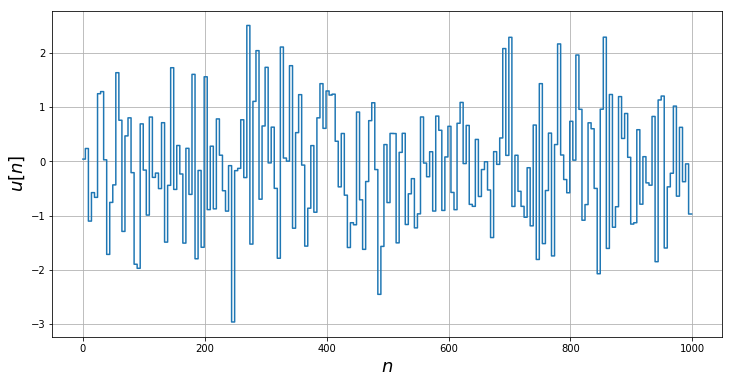

In [24]:
# Plot
_, ax = plt.subplots(figsize=(12, 6))
ax.step(n, u)
ax.set_xlabel("$n$", fontsize=18)
ax.set_ylabel("$u[n]$", fontsize=18)
ax.grid()
plt.show()

##  System simulation

The defined system will be simulated for the given input.

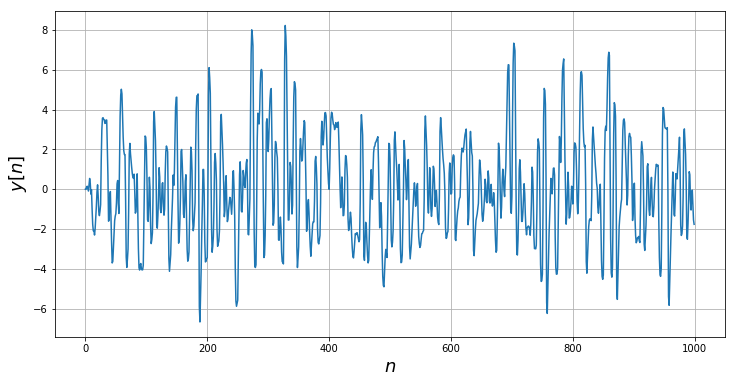

In [25]:
# Initialize input
y = np.empty_like(u)

# Initial Conditions
y0 = [0, 0]

# Simulate it
y[0:2] = y0
for i in range(2, len(y)):
    y[i] = system_equation([y[i-1], y[i-2]], [u[i-1], u[i-2]])+np.random.normal(scale=0.1)
    
# Plot
_, ax = plt.subplots(figsize=(12, 6))
ax.plot(n, y)
ax.set_xlabel("$n$", fontsize=18)
ax.set_ylabel("$y[n]$", fontsize=18)
ax.grid()
plt.show()

## Adding output noise

Some gaussian white output noise with standart deviation $1.0$ will be added to the data.

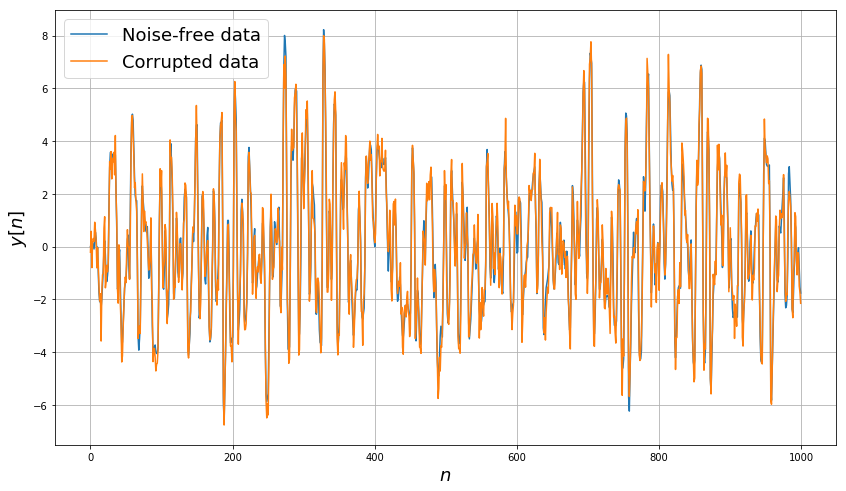

In [26]:
# Noise free data
ynoise_free = y

# Generate noise
v = np.random.normal(scale=0.5, size=y.shape)

# Data corrupted with noise
ynoisy = ynoise_free + v

# Plot
_, ax = plt.subplots(figsize=(14, 8))
ax.plot(n, ynoise_free, label='Noise-free data')
ax.plot(n, ynoisy, label='Corrupted data')
ax.set_xlabel("$n$", fontsize=18)
ax.set_ylabel("$y[n]$", fontsize=18)
ax.grid()
ax.legend(fontsize=18)
plt.show()

## Validation data and identification data
The data will be divided into validation and identification data. The first 600 values will be used
for identification and the last 400 values for validation. The validation data will be free of noise,
so the model quality may be better assessed.

In [27]:
Ni = 700
Nv = len(y) - Ny

# Identification data
yi = ynoisy[:Ni]
ui = u[:Ni]

# Validation data
yv = ynoise_free[Ni:]
uv = u[Ni:]

# Neural Network Parameter Estimation

## Set problem
A neural network model will be fit to the identification data, minimizing simulation error. The system will consider $y[n-1]$, $y[n-2]$, $u[n-1]$ and $u[n-2]$ as inputs for the neural network. Two hidden layers with
10 hidden nodes each will be considered.

The simulation error will be minimized in order to find the parameters.

In [28]:
# Feed forward model
mdl = narx.FeedforwardNetwork(2, 2, [30])

# Reshape data
yi = yi.reshape((-1, 1))
ui = ui.reshape((-1, 1))

# Define Simulation Error
sim_error = narx.SimulationError(mdl, yi, ui, maxlength=6000)
predict_error = narx.PredictionError(mdl, yi, ui)
    
# Define Input and Output bounds
ybounds = [[-6, 6]]
ubounds = [[-2, 2]]

# Get initial guess for the parameters
initial_guess = mdl.params_random_guess(ybounds, ubounds)

## Solve optimization problem

In [29]:
tic()
params_predict, info = predict_error.lsq_estimate_parameters(initial_guess, max_nfev=100)
toc()

Elapsed time is 17.8364839554 seconds.


In [30]:
tic()
params, info = sim_error.lsq_estimate_parameters(initial_guess, use_sparse=False,max_nfev=100)
toc()

Elapsed time is 21.6483960152 seconds.


# Validation

Simulate data on Validation Interval

0.113729208685
0.583609033208


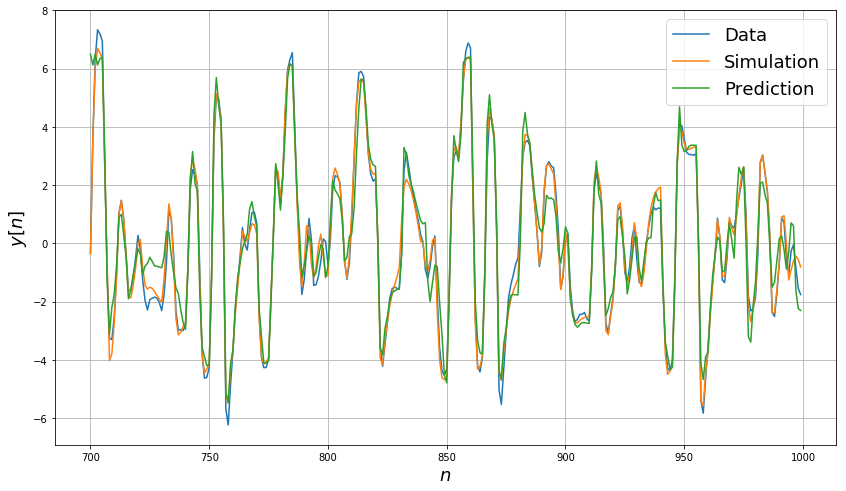

In [31]:
ys = narx.simulate(mdl, [[yv[0]], [yv[1]]], uv.reshape((-1, 1)), params)
ys = np.hstack(([yv[0], yv[1]],ys[:-1].flatten()))
yp = narx.simulate(mdl, [[yv[0]], [yv[1]]], uv.reshape((-1, 1)), params_predict)
yp = np.hstack(([yp[0,0], yp[1,0]],yp[:-1].flatten()))

mse_s = np.mean((yv.flatten()-ys.flatten())**2)
print(mse_s)
mse_p = np.mean((yv.flatten()-yp.flatten())**2)
print(mse_p)

# Plot
_, ax = plt.subplots(figsize=(14, 8))
ax.plot(n[Ni:], yv, label='Data')
ax.plot(n[Ni:], ys, label='Simulation')
ax.plot(n[Ni:], yp, label='Prediction')
ax.set_xlabel("$n$", fontsize=18)
ax.set_ylabel("$y[n]$", fontsize=18)
ax.grid()
ax.legend(fontsize=18)
plt.show()